# Band Excitation Piezoresponse Force Microscopy(BE-PFM)
### Machine Learning Application
Erin Akinjide
## Objective

This assignment focuses on applying machine learning techniques to my band excitation dataset to explore the features that influence ferroelectric switching. I extend my initial data visualization, preprocess my data, train machine learning models, and evaluate their performance. The goal is to deepen my understanding of machine learning workflows and to enhance my skills in data handling and model evaluation.


## Initial Data Visualization
Band Excitation Piezoresponse Force Microscopy (BE-PFM), an advanced microscopy technique, involves measuring piezoresponse across a range of frequencies near cantilever resonance. A bipolar-triangular switching waveform is applied to fully switch the material. 

The resulting data, acquired at every pixel (60x60), provides information on amplitude (A), phase (ϕ), resonance frequency (ω), and quality factor (Q) after fitting. These parameters offer qualitative insights into piezoresponse, polarization direction, stiffness, and dampening at various voltages (V, length = 96).


#### Load Dataset

In [11]:
import h5py
import matplotlib.pyplot as plt
from scipy import io
import numpy as np
from scipy.signal import savgol_filter

In [12]:
data_h5_path = r'C:\Users\erina\Finalproject_BandExcitation\src\Data.h5'
validation_h5_path = r'C:\Users\erina\Finalproject_BandExcitation\src\loop_1.h5'

with h5py.File(data_h5_path, 'r') as h5_data_file, \
        h5py.File(validation_h5_path, 'r') as h5_validation_file:

    # Extract the important information from the HDF5 files
    raw = {
        'voltage': h5_data_file['Voltagedata_mixed'][:],
        'piezoresponse': h5_data_file['Loopdata_mixed'][:],
        'amplitude': h5_data_file['OutA2_mixed'][:],
        'phase': h5_data_file['OutPhi1_mixed'][:],
        'resonance': h5_data_file['Outw2_mixed'][:],
        'quality_factor': h5_data_file['OutQ2_mixed'][:],
        'val_piezoresponse': h5_validation_file['piezo_1'][:],
        'val_resonance': h5_validation_file['resonance_loop_1'][:]
    }

# Now 'raw' dictionary contains the extracted data from the HDF5 files
# Check dimensions of different groups
for key, value in raw.items():
    print(f"Group: {key}, Dimensions: {value.shape}")

Group: voltage, Dimensions: (96, 1)
Group: piezoresponse, Dimensions: (60, 60, 96)
Group: amplitude, Dimensions: (60, 60, 96)
Group: phase, Dimensions: (60, 60, 96)
Group: resonance, Dimensions: (60, 60, 96)
Group: quality_factor, Dimensions: (60, 60, 96)
Group: val_piezoresponse, Dimensions: (60, 60, 96)
Group: val_resonance, Dimensions: (60, 60, 96)


##### Line Plot Showing Priezoresponse as a function of Voltage for three Pixel Location on the Material

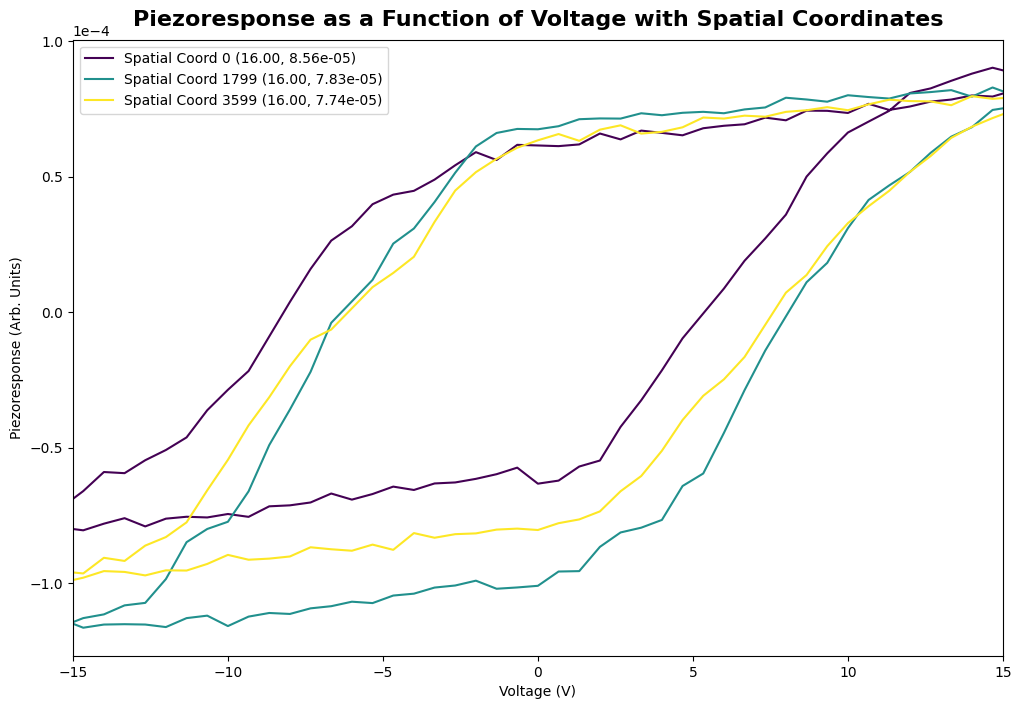

In [13]:
# Extract relevant data for plotting
voltage_values = raw['voltage'].reshape(-1)  # Flatten the voltage array
piezoresponse_data = raw['piezoresponse'].reshape((60 * 60, 96))  # Reshape the piezoresponse data

# Select 5 evenly spaced spatial coordinates for better visibility
spatial_locations_to_plot = np.linspace(0, piezoresponse_data.shape[0] - 1, 3, dtype=int)

# Create a single plot with spatial coordinates represented as colors
fig, ax = plt.subplots(figsize=(12, 8))

# Iterate over selected spatial locations and plot piezoresponse against voltage
for i in spatial_locations_to_plot:
    x_coords = voltage_values
    y_coords = piezoresponse_data[i, :]
    ax.plot(x_coords, y_coords,
            label=f'Spatial Coord {i} ({x_coords[0]:.2f}, {y_coords[0]:.2e})',
            color=plt.cm.viridis(i / piezoresponse_data.shape[0]))

# Set x-axis limits
ax.set_xlim(-15, 15)

# Set x and y axis labels with units
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Piezoresponse (Arb. Units)')

# Add legend
ax.legend()

# Use scientific notation for y-axis ticks
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.title('Piezoresponse as a Function of Voltage with Spatial Coordinates', fontsize=16, fontweight='bold', pad=10)
plt.show()

The roughness in the Line plot above indicates some noise in the signal the data set will need go through filtering preprocessing.

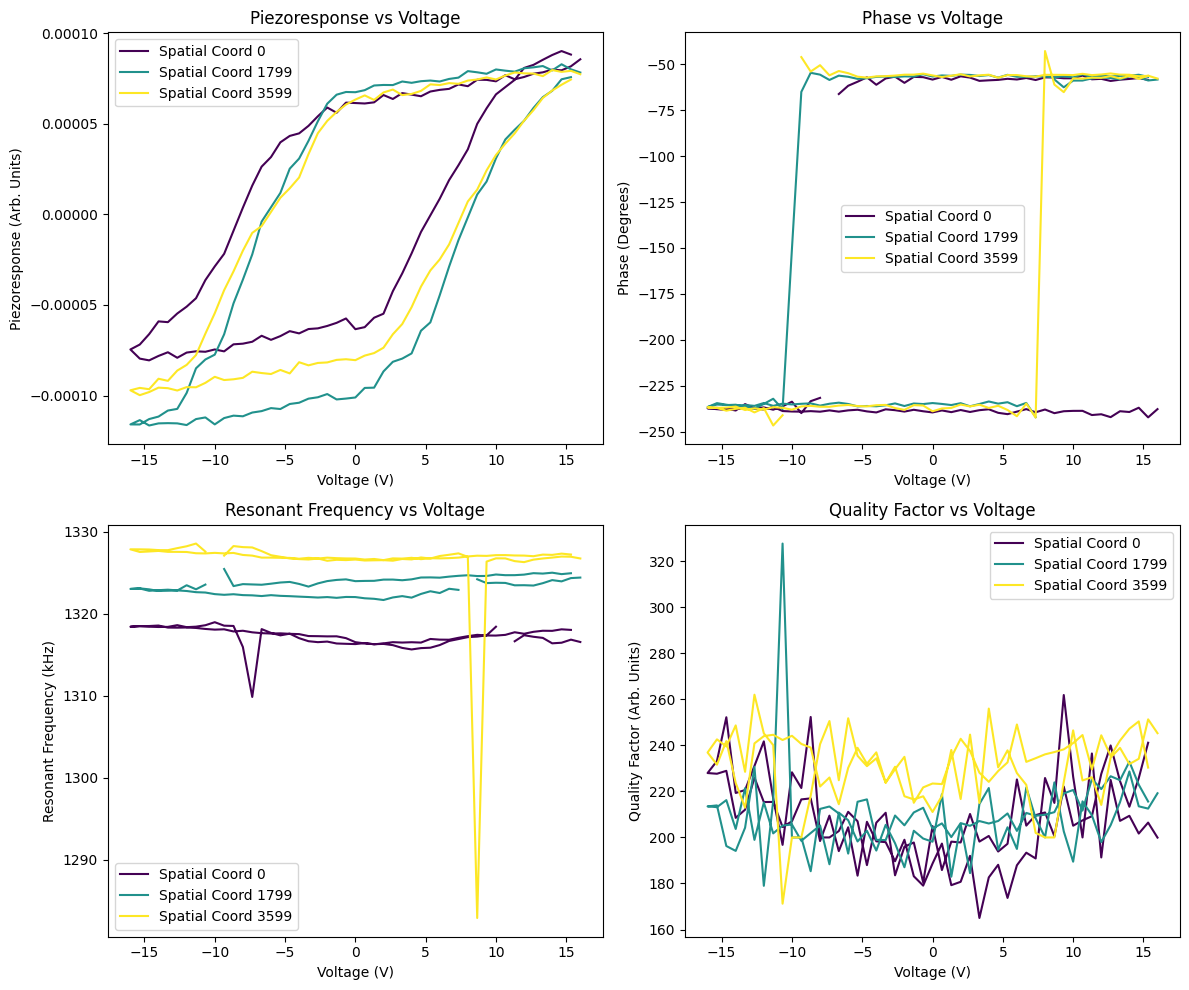

In [14]:
# Extract relevant data for plotting
voltage_values = raw['voltage'].reshape(-1)  # Flatten the voltage array
piezoresponse_data = raw['piezoresponse'].reshape((60 * 60, 96))  # Reshape the piezoresponse data
phase_data = raw['phase'].reshape((60 * 60, 96))  # Reshape the phase data
resonance_data = raw['resonance'].reshape((60 * 60, 96))  # Reshape the resonance data
quality_factor_data = raw['quality_factor'].reshape((60 * 60, 96))  # Reshape the quality factor data

# Set up a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Select 3 evenly spaced spatial coordinates for better visibility
spatial_locations_to_plot = np.linspace(0, piezoresponse_data.shape[0] - 1, 3, dtype=int)

# Plot 1: Piezoresponse vs Voltage
axs[0, 0].set_prop_cycle('color', plt.cm.viridis(np.linspace(0, 1, len(spatial_locations_to_plot))))
for i in spatial_locations_to_plot:
    axs[0, 0].plot(voltage_values, piezoresponse_data[i, :], label=f'Spatial Coord {i}')
axs[0, 0].set_xlabel('Voltage (V)')
axs[0, 0].set_ylabel('Piezoresponse (Arb. Units)')
axs[0, 0].set_title('Piezoresponse vs Voltage')
axs[0, 0].legend()

# Plot 2: Phase vs Voltage
axs[0, 1].set_prop_cycle('color', plt.cm.viridis(np.linspace(0, 1, len(spatial_locations_to_plot))))
for i in spatial_locations_to_plot:
    axs[0, 1].plot(voltage_values, phase_data[i, :], label=f'Spatial Coord {i}')
axs[0, 1].set_xlabel('Voltage (V)')
axs[0, 1].set_ylabel('Phase (Degrees)')
axs[0, 1].set_title('Phase vs Voltage')
axs[0, 1].legend()

# Plot 3: Resonant frequency vs Voltage
axs[1, 0].set_prop_cycle('color', plt.cm.viridis(np.linspace(0, 1, len(spatial_locations_to_plot))))
for i in spatial_locations_to_plot:
    axs[1, 0].plot(voltage_values, resonance_data[i, :], label=f'Spatial Coord {i}')
axs[1, 0].set_xlabel('Voltage (V)')
axs[1, 0].set_ylabel('Resonant Frequency (kHz)')
axs[1, 0].set_title('Resonant Frequency vs Voltage')
axs[1, 0].legend()

# Plot 4: Quality Factor vs Voltage
axs[1, 1].set_prop_cycle('color', plt.cm.viridis(np.linspace(0, 1, len(spatial_locations_to_plot))))
for i in spatial_locations_to_plot:
    axs[1, 1].plot(voltage_values, quality_factor_data[i, :], label=f'Spatial Coord {i}')
axs[1, 1].set_xlabel('Voltage (V)')
axs[1, 1].set_ylabel('Quality Factor (Arb. Units)')
axs[1, 1].set_title('Quality Factor vs Voltage')
axs[1, 1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

plt.show()


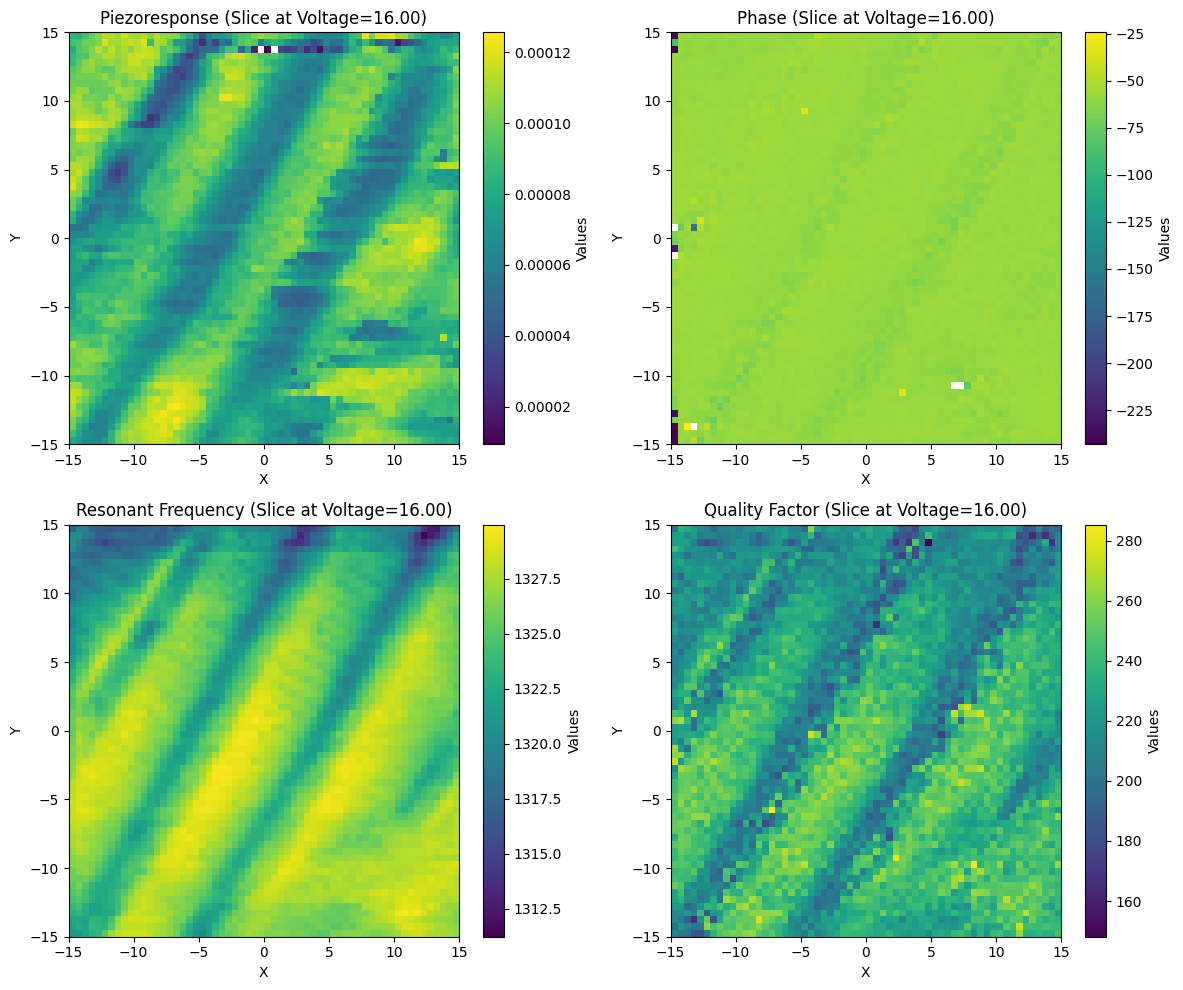

In [15]:
# Extract relevant data for plotting
voltage_values = raw['voltage'].reshape(-1)  # Flatten the voltage array
features_data = {
    'Piezoresponse': raw['piezoresponse'].reshape((60, 60, 96)),
    'Phase': raw['phase'].reshape((60, 60, 96)),
    'Resonant Frequency': raw['resonance'].reshape((60, 60, 96)),
    'Quality Factor': raw['quality_factor'].reshape((60, 60, 96)),
}

# Set up a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot heatmaps for each feature
for i, (feature_name, feature_data) in enumerate(features_data.items()):
    ax = axs.flatten()[i]
    im = ax.imshow(feature_data[:, :, 0], cmap='viridis', extent=(-15, 15, -15, 15), aspect='auto')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'{feature_name} (Slice at Voltage={voltage_values[0]:.2f})')
    fig.colorbar(im, ax=ax, label='Values')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

plt.show()

### Data Preprocessing Guide

The line plots above and heatmap indicate that the data needs various forms of preprocessing before any further steps.

Define a set of functions for filtering and processing data, commonly used in signal processing and data analysis. Here's a brief explanation of each function:

1. *range_filter(data, min_max):*

Purpose: Applies a max-min filter to the input data, clipping values outside the specified range (min_max).
Usage: Removes outliers or data points that fall outside the desired range.

2. *clean_interpolate(data, method='linear'):*

Purpose: Interpolates data to handle non-real values in the input data, typically arising from fitting failures or missing values.
Usage: Ensures a continuous and smooth representation of the data by filling in missing or non-real values using interpolation.

3. *savgol(data, fit_type='linear'):*

Purpose: Applies the Savitzky-Golay filter to the input data, a technique for smoothing noisy signals while preserving important features.
Usage: Removes high-frequency noise from the data, making it suitable for subsequent analysis and visualization.

4. *normalize(data, reference=None):*

Purpose: Normalizes the input data by subtracting the mean and dividing by the standard deviation. The optional reference parameter allows normalization based on a reference dataset.
Usage: Ensures that different signals or parameters are on a similar scale, facilitating comparison and analysis.

In [16]:
def range_filter(data, min_max):
    # Apply max min filter on the data to remove bad points
    data_filtered = np.clip(data, min_max[0], min_max[1])
    return data_filtered

def clean_interpolate(data, method='linear'):
    # Interpolate data to handle non-real values
    cleaned_data = np.apply_along_axis(lambda x: np.interp(np.arange(len(x)), np.where(np.isreal(x))[0], x[np.isreal(x)]),
                                       axis=-1, arr=data)
    return cleaned_data

def savgol(data, fit_type='linear'):
    # Use Savitzky-Golay filter to remove outlier points
    filtered_data = savgol_filter(data, window_length=5, polyorder=3, mode='mirror')
    return filtered_data

def normalize(data, reference=None):
    # Normalize the data
    if reference is None:
        reference = data
    normalized_data = (data - np.mean(reference, axis=0)) / np.std(reference, axis=0)
    return normalized_data


##### Process the Important groups Using Defined Functions

In [18]:
# Open the HDF5 files
h5_data_file_path = r'C:\Users\erina\FinalProject_Band_Excitation\src\Data.h5'  # Replace with the actual path
h5_validation_file_path = r'C:\Users\erina\FinalProject_Band_Excitation\src\loop_1.h5'  # Replace with the actual path

with h5py.File(h5_data_file_path, 'r') as h5_data_file, \
        h5py.File(h5_validation_file_path, 'r') as h5_validation_file:

    # Extract the important information from the HDF5 files
    raw = {
        'voltage': h5_data_file['Voltagedata_mixed'][:],
        'piezoresponse': h5_data_file['Loopdata_mixed'][:],
        'amplitude': h5_data_file['OutA2_mixed'][:],
        'phase': h5_data_file['OutPhi1_mixed'][:],
        'resonance': h5_data_file['Outw2_mixed'][:],
        'quality_factor': h5_data_file['OutQ2_mixed'][:],
        'val_piezoresponse': h5_validation_file['piezo_1'][:],
        'val_resonance': h5_validation_file['resonance_loop_1'][:]
    }

    # Add a max-min filter on the data to remove bad points
    p_min_max = [1300, 1340]
    raw['resonance'] = range_filter(raw['resonance'], p_min_max)
    raw['val_resonance'] = range_filter(raw['val_resonance'], p_min_max)

    # Interpolate data that is non-real (SHO fit failure)
    interpolated = {
        'voltage': raw['voltage'],
        'piezoresponse': clean_interpolate(raw['piezoresponse']),
        'amplitude': clean_interpolate(raw['amplitude']),
        'phase': clean_interpolate(raw['phase']),
        'resonance': clean_interpolate(raw['resonance']),
        'quality_factor': clean_interpolate(raw['quality_factor']),
        'val_piezoresponse': clean_interpolate(raw['val_piezoresponse']),
        'val_resonance': clean_interpolate(raw['val_resonance'])
    }

    # Use Savitzky-Golay filter to remove outlier points
    sg_filtered = {
        'voltage': raw['voltage'],
        'piezoresponse': savgol(interpolated['piezoresponse']),
        'amplitude': savgol(interpolated['amplitude']),
        'phase': savgol(interpolated['phase']),
        'resonance': savgol(interpolated['resonance']),
        'quality_factor': savgol(interpolated['quality_factor']),
        'val_piezoresponse': savgol(interpolated['val_piezoresponse']),
        'val_resonance': savgol(interpolated['val_resonance'])
    }

    # Normalize the data
    normalized = {
        'voltage': raw['voltage'],
        'piezoresponse': normalize(sg_filtered['piezoresponse']),
        'amplitude': normalize(sg_filtered['amplitude']),
        'phase': normalize(sg_filtered['phase']),
        'resonance': normalize(sg_filtered['resonance']),
        'quality_factor': normalize(sg_filtered['quality_factor']),
        'val_piezoresponse': normalize(sg_filtered['val_piezoresponse'], sg_filtered['piezoresponse']),
        'val_resonance': normalize(sg_filtered['val_resonance'], sg_filtered['resonance'])
    }

    # Stores information which helps in making pretty axes
    signal_info = {
        'voltage': dict(
            symbol='voltage',
            format_str='%3.d',
            units='Voltage (V)',
            y_lim=None,
            x_tick=np.linspace(-15, 15, 7),
            pca_range=None),
        'amplitude': dict(
            symbol='A',
            format_str='%.0e',
            units='Amplitude (Arb. U.)',
            y_lim=None,
            y_tick=[],
            pca_range=None),
        'phase': dict(
            symbol='Phi',
            format_str='%3.d',
            units='Phase (${^\circ}$)',
            y_lim=[-110, 110],
            y_tick=np.linspace(-90, 90, 5),
            pca_range=None),
        'resonance': dict(
            symbol='w',
            format_str='%3.d',
            units='Resonance (kHz)',
            y_lim=[1326, 1329],
            y_tick=np.linspace(1320, 1329, 4),
            pca_range=None),
        'quality_factor': dict(
            symbol='Q',
            format_str='%3.f',
            units='Quality Factor (Arb. U.)',
            y_lim=[210, 310],
            y_tick=np.linspace(215, 310, 5),
            pca_range=None),
        'piezoresponse': dict(
            symbol='Piezoresponse',
            format_str='%.0e',
            units='Piezoresponse (Arb. U.)',
            y_lim=None,
            y_tick=[],
            pca_range=[-0.29, .29])
    }

    # Builds a single dictionary to hold all the data
    data = {
        'raw': raw,
        'interpolated': interpolated,
        'sg_filtered': sg_filtered,
        'normalized': normalized,
        'signal_info': signal_info
    }


<>:80: SyntaxWarning: invalid escape sequence '\c'
<>:80: SyntaxWarning: invalid escape sequence '\c'
C:\Users\erina\AppData\Local\Temp\ipykernel_36080\4029038332.py:80: SyntaxWarning: invalid escape sequence '\c'
  units='Phase (${^\circ}$)',
C:\Users\erina\AppData\Local\Temp\ipykernel_36080\4029038332.py:80: SyntaxWarning: invalid escape sequence '\c'
  units='Phase (${^\circ}$)',


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'C:\Users\erina\FinalProject_Band_Excitation\src\Data.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Visualization of Preprocessed Data

## Model Evaluation Visualization


## Machine Learning Challenge Description

## Model Training and Hyparameter Tuning



## Improvement Strategies

